In [64]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

print("IMPORTS IMPORTED")

IMPORTS IMPORTED


In [65]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('C:\\Users\\jamie\\Untitled Folder 1\\Human_Activity_Dataset\\Seizure\\Datasets\\Datasets\\ds\\ds\\ds\\mergedfiles.txt', header = None, names = columns)
df = df.dropna()
print(columns)

C:\Users\jamie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']


In [66]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,5,Seizure,3.402408e+13,6.193,6.790,2.36;
1,5,Seizure,3.402413e+13,6.349,6.969,2.995;
2,5,Seizure,3.402418e+13,6.532,7.079,3.317;
3,5,Seizure,3.402423e+13,6.886,6.961,2.923;
4,5,Seizure,3.402428e+13,7.019,6.709,2.175;


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1138266 entries, 0 to 1138266
Data columns (total 6 columns):
user         1138266 non-null object
activity     1138266 non-null object
timestamp    1138266 non-null float64
x-axis       1138266 non-null float64
y-axis       1138266 non-null float64
z-axis       1138266 non-null object
dtypes: float64(3), object(3)
memory usage: 60.8+ MB


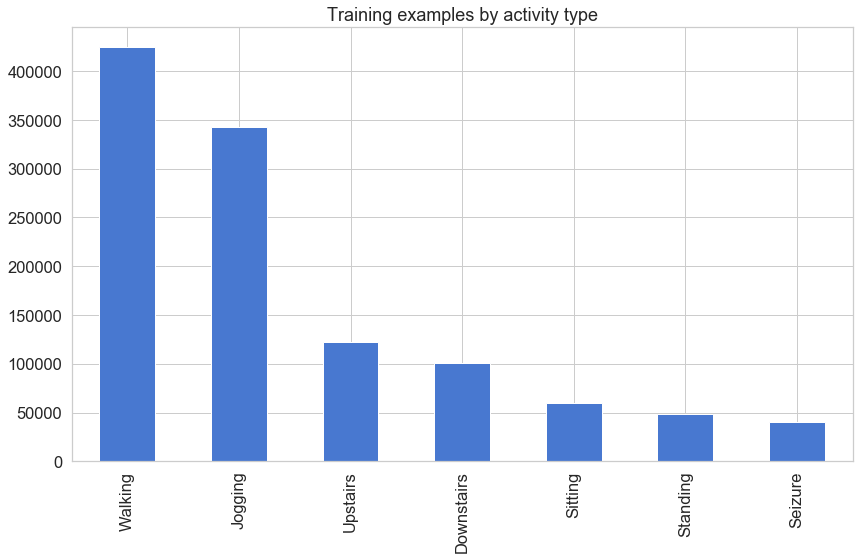

In [68]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

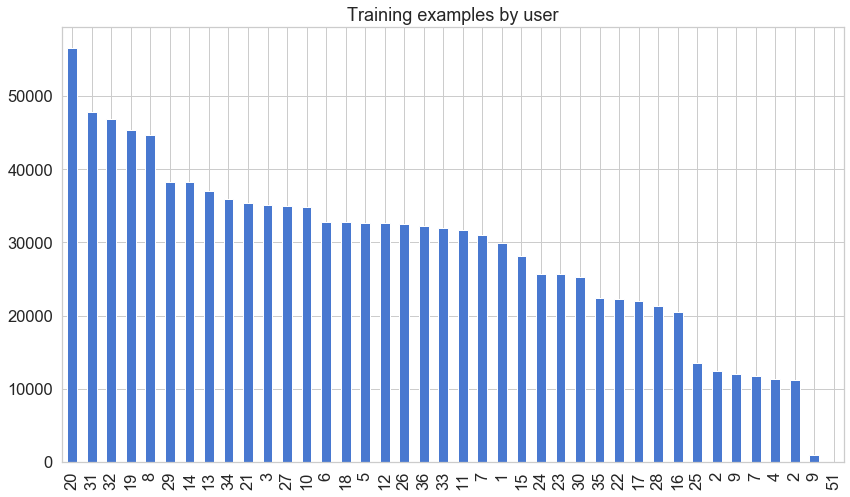

In [69]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user');

In [70]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:500]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
        
        
# Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


df.head()


,user,activity,timestamp,x-axis,y-axis,z-axis
0,5,Seizure,3.402408e+13,6.193,6.790,2.36;
1,5,Seizure,3.402413e+13,6.349,6.969,2.995;
2,5,Seizure,3.402418e+13,6.532,7.079,3.317;
3,5,Seizure,3.402423e+13,6.886,6.961,2.923;
4,5,Seizure,3.402428e+13,7.019,6.709,2.175;


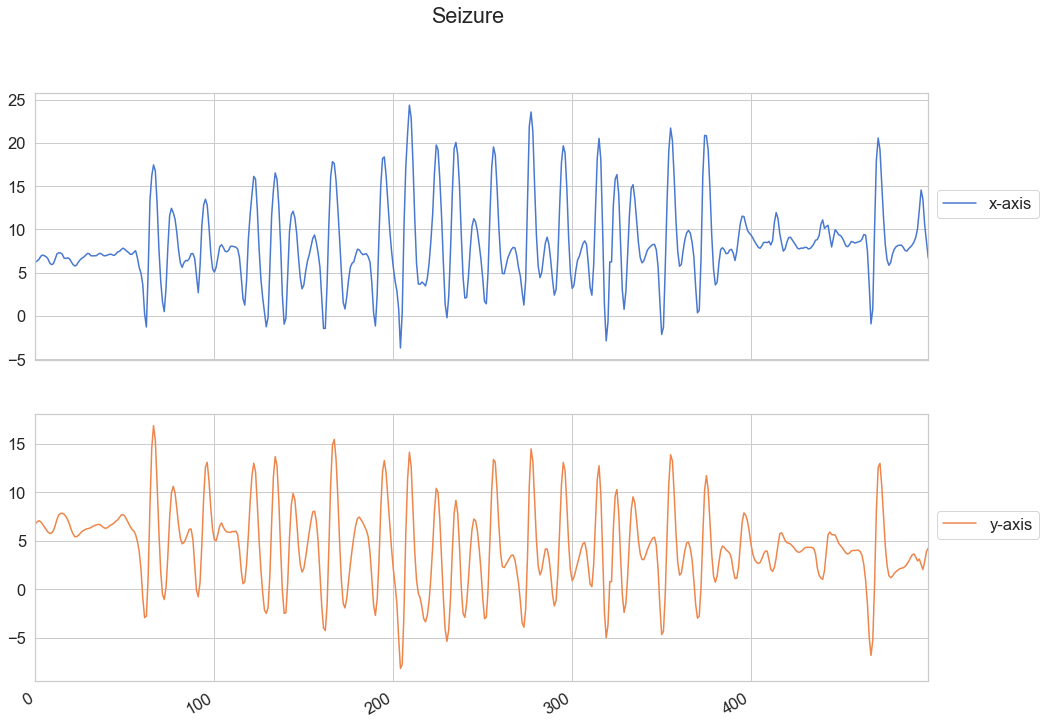

In [71]:
plot_activity("Seizure", df)


Data preprocessing
Our LSTM (covered in the previous part of the series) model expects fixed-length sequences as training data. We'll use a familiar method for generating these. Each generated sequence contains 200 training examples:

In [72]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

C:\Users\jamie\Anaconda3\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [73]:
np.array(segments).shape



(56904, 3, 200)

In [74]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [75]:
reshaped_segments.shape


(56904, 200, 3)

In [76]:
labels[0]


array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [78]:
len(X_train)

45523

In [79]:
len(X_test)


11381

# Building the model

Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:



In [80]:
N_CLASSES = 7
N_HIDDEN_UNITS = 64
print("YAY")

YAY


In [81]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [82]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [83]:

pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [84]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [85]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

In [86]:
N_EPOCHS = 50
BATCH_SIZE = 1024
print("YAY")

YAY


In [ ]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} f loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} Final loss: {loss_final}')

In [ ]:
InteractiveSession.close()

In [36]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

NotFoundError: Failed to create a NewWriteableFile: .\./checkpoint/har.pbtxt.tmpc28322c6c00846aba9e556e27905f4de : The system cannot find the path specified.
; No such process

In [ ]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

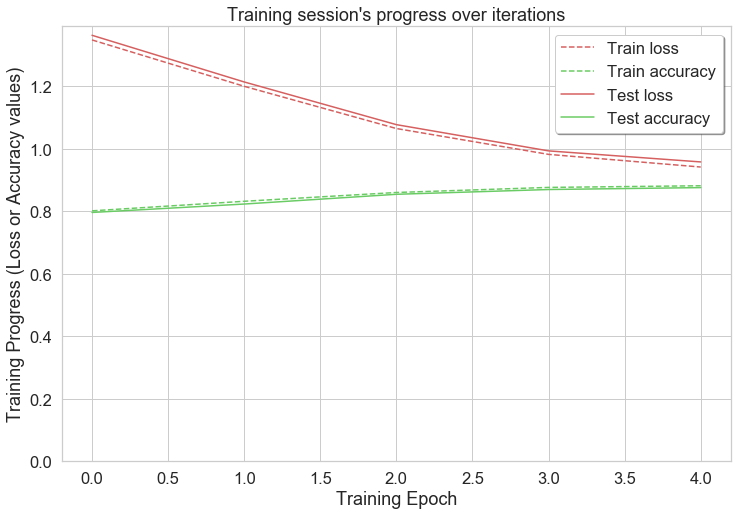

In [55]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [56]:
np.summary()

AttributeError: module 'numpy' has no attribute 'summary'

In [57]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking','Seizure']
print(LABELS)


['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking', 'Seizure']


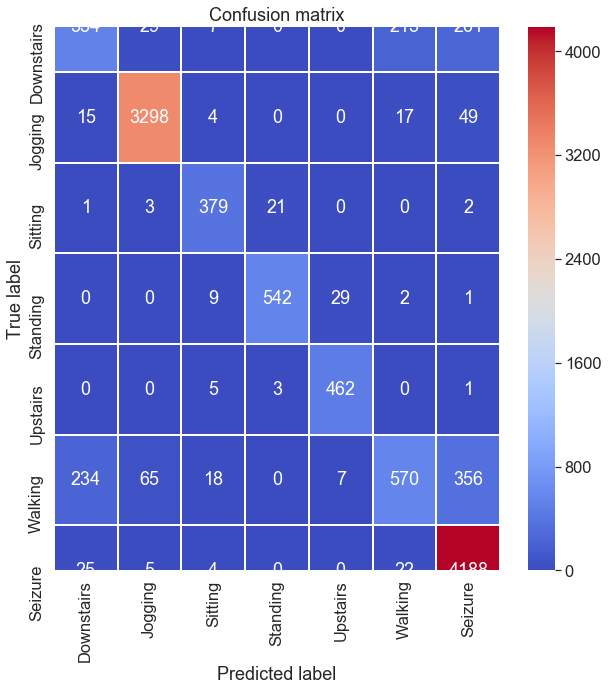

In [62]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, linewidths=1, annot=True, fmt="d",cmap='coolwarm', linecolor='white');
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [63]:
# Take the class with the highest probability from the test predictions
#max_test = np.argmax(y_pred_test, axis=1)
#max_y_test = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
print(classification_report(max_test, max_predictions))

              precision    recall  f1-score   support

           0       0.66      0.51      0.58      1044
           1       0.97      0.97      0.97      3383
           2       0.89      0.93      0.91       406
           3       0.96      0.93      0.94       583
           4       0.93      0.98      0.95       471
           5       0.69      0.46      0.55      1250
           6       0.86      0.99      0.92      4244

    accuracy                           0.88     11381
   macro avg       0.85      0.82      0.83     11381
weighted avg       0.87      0.88      0.87     11381

